<a href="https://colab.research.google.com/github/babyraggge/time-data-prediction-methods/blob/main/practice8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Методы прогнозирования на основе искусственных нейронных сетей

Бельтюков
РИ-481223

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Загрузим ВР из файла Fort.mat, содержащий отсчеты некоторого реального ВР, всего 174 отсчета в вектор-строке, и отмаштабируем его  в  диапазон  от  0  до  1,  так  как  функция  активации  слоя LSTM корректно обрабатывает значения только в данном диапазоне:

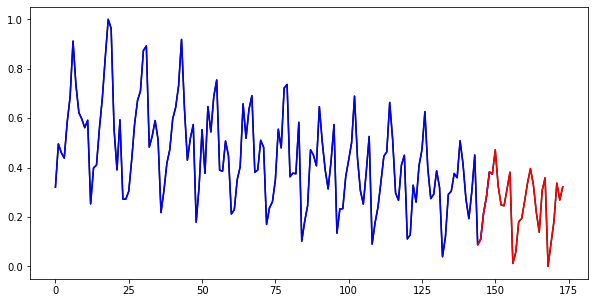

In [3]:
file = h5py.File('Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)
F = Fort

scaler = MinMaxScaler(feature_range=(0, 1))
F = scaler.fit_transform(F)
F_tr = F[:150]
F_test = F[144:]

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(np.r_[:150],F_tr, 'b')
plt.plot(np.r_[144:174],F_test, 'r')
plt.show()

Произведем  предобработку  исходных  данных  в  формат, понимаемый  слоем LSTM-сети,  в  виде «порций»  (batches)  для обучения/валидации.  Ниже  приведен  пример  для  модели  сети  6 порядка авторегрессии на (150-6)=144 смежных точках ряда.

In [4]:
data_gen = TimeseriesGenerator(F_tr, 
                               F_tr,
                               length=6, 
                               sampling_rate=1,
                               batch_size=150)

batch_0 = data_gen[0]
x, y= batch_0 # вход и обучающий выход для сети
print(x.shape) # 144 точки обучения, прогноз 1 точки по 6 прошлым
xx_tr=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy_tr=y
print(xx_tr.shape)# меняем местами размерности
print(yy_tr.shape)

(144, 6, 1)
(144, 1, 6)
(144, 1)


Составляем  модель  прогнозной  сети.  В  простейшем случае  нам  понадобится  только  1  внутренний LSTM-слой  и  1 выходной слой. Тогда модель строится как:

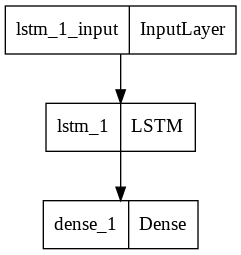

In [6]:
from keras.utils.vis_utils import plot_model

model = Sequential()# слои соединены последовательно
model.add(LSTM(units=20, input_shape=(1, 6))) # 20 нейронов
model.add(Dense(units=1)) # выход одномерный

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png') # рисунок полученной сети

Добавим Dropout слои,  которые  со  случайной заданной вероятностью  обнуляют  входы  следующего  слоя  при обучении,  тем  самым  позволяя  избежать  переобучения  всей нейронной сети в целом. Например, модель из 3 слоев LSTM может быть построена примерно следующим образом:

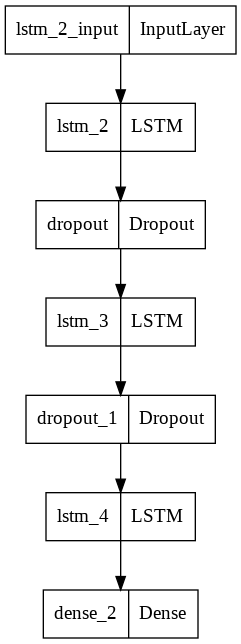

In [7]:
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(1, 6)))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png')

Производим обучение модели:

In [10]:
model.fit(xx_tr, yy_tr, epochs=100) # 100 эпох по 144 точки

Epoch 1/100
5/5 [==============================] - 5s 6ms/step - loss: 0.2290
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.2179
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.2075
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.1963
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1847
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.1713
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1580
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.1424
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 0.1251
Epoch 10/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1056
Epoch 11/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0849
Epoch 12/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0659
Epoch 13/100
5/5 [==============================] - 0s 6ms/st

Построим ретроспективный  прогноз,  с  переходом  обратно  к  исходному масштабу данных:

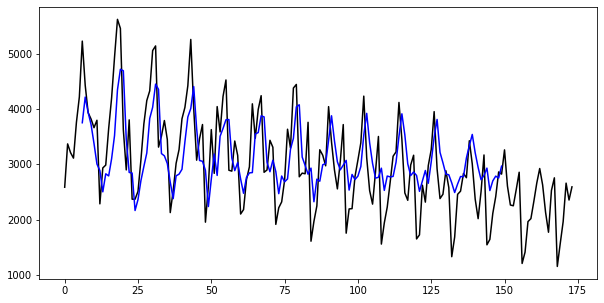

In [11]:
trainPredict = model.predict(xx_tr)
trainPredict = scaler.inverse_transform(trainPredict)

plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[6:150], trainPredict,'b')
plt.show()

Для тестовой  проверки  прогноза  преобразуем  исходные  точки в формат, понятный для модели LSTM-сети:

In [12]:
data_gen = TimeseriesGenerator(F_test, 
                               F_test,
                               length=6, 
                               sampling_rate=1,
                               batch_size=150)

batch_0 = data_gen[0]
x, y = batch_0
xx_test = np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy_test = y

print(xx_test.shape) # прогноз на 24 точки по 6 наблюдениям
print(yy_test.shape) #

(24, 1, 6)
(24, 1)


Строим получившийся тестовый прогноз в нужном масштабе:

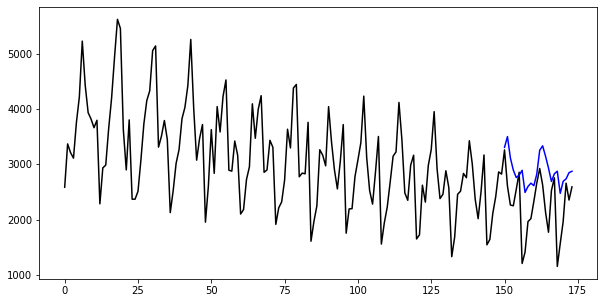

In [13]:
testPredict = model.predict(xx_test)
testPredict = scaler.inverse_transform(testPredict)

plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[150:174], testPredict, 'b')
plt.show()

Еще раз импортируем

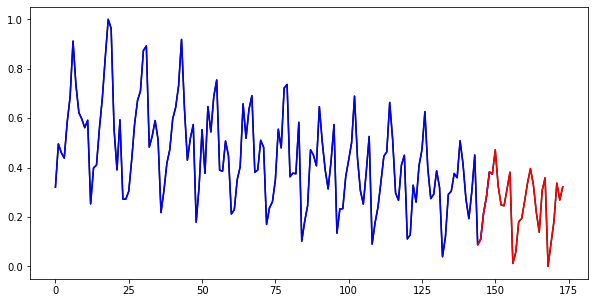

In [14]:
file = h5py.File('Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)
F = Fort
look_back = 6
threshold = 150

scaler = MinMaxScaler(feature_range=(0, 1))
F = scaler.fit_transform(F)
F_tr = F[:threshold]
F_test = F[threshold-look_back:]

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(np.r_[:threshold], F_tr, 'b')
plt.plot(np.r_[threshold-look_back:F.shape[0]], F_test, 'r')
plt.show()

Для удобства будем использовать генераторы полностью:

In [22]:
train_data_gen = TimeseriesGenerator(F_tr, 
                                     F_tr,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=3)

test_data_gen = TimeseriesGenerator(F_test, 
                                    F_test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1)

In [23]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.5))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(train_data_gen, epochs=100)

Epoch 1/100
48/48 [==============================] - 3s 7ms/step - loss: 0.0833
Epoch 2/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0423
Epoch 3/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0397
Epoch 4/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0430
Epoch 5/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0375
Epoch 6/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0377
Epoch 7/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0377
Epoch 8/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0384
Epoch 9/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0365
Epoch 10/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0458
Epoch 11/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0388
Epoch 12/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0384
Epoch 13/100
48/48 [=================

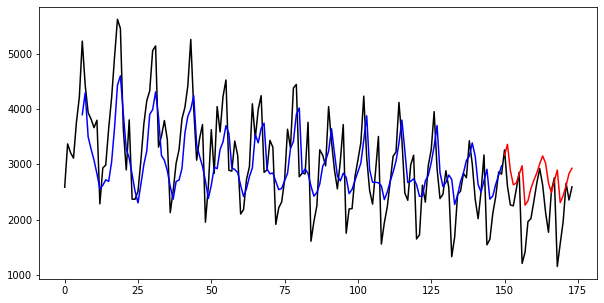

In [24]:
trainPredict = model.predict(train_data_gen)
testPredict = model.predict(test_data_gen)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[look_back:threshold], trainPredict,'b')
plt.plot(np.r_[threshold:F.shape[0]], testPredict, 'r')
plt.show()

Построим прогноз на 256 точек  для  следующего модельного временного ряда:

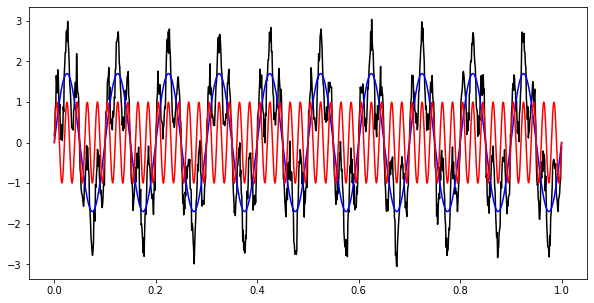

In [66]:
import numpy.random

t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 50
F = 1.7 * np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + 0.2 * np.random.randn(len(t))

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, 1.7*np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.show()

Несмотря на то, что данные находятся в промежутке от -3 до 3, отмаштабируем их до диапазона 0–1, который является диапазоном значений с плавающей запятой, где у нас наибольшая точность. Также разобьем на обучающие и тестовые данные:

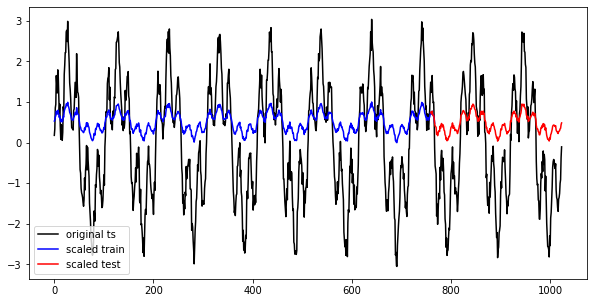

In [74]:
look_back = 9
threshold = 768

scaler = MinMaxScaler(feature_range=(0, 1))
Fs = scaler.fit_transform(F.reshape(-1, 1))
F_tr = Fs[:threshold]
F_test = Fs[threshold-look_back:]

plt.figure(figsize = (10, 5))
plt.plot(F, 'k', label = 'original ts')
plt.plot(np.r_[:threshold], F_tr, 'b', label='scaled train')
plt.plot(np.r_[threshold-look_back:F.shape[0]], F_test, 'r', label='scaled test')
plt.legend()
plt.show()

In [75]:
train_data_gen = TimeseriesGenerator(F_tr, 
                                     F_tr,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=3)

test_data_gen = TimeseriesGenerator(F_test, 
                                    F_test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1)

Для поиска оптимальной модели на основе LSTM, воспользуемся KerasTuner, который на основе функции-сборщика модели будет строить и обучать различные вариатны нейронной сети и сравнивать их между собой по метрике MSE. Модель с наименьшим MSE и будет оптимальной моделью для данного временного ряда. 

In [29]:
def build_model(hp):
  model = Sequential()

  model.add(LSTM(hp.Int('input_unit', min_value=35, max_value=50, step=5), 
                 return_sequences=True, 
                 input_shape=(train_data_gen[0][0].shape[1], (train_data_gen[0][0].shape[2]))))
  
  for i in range(hp.Int('n_layers', 1, 3)):
    model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=35,max_value=50,step=5), 
                   return_sequences=True))

  model.add(LSTM(hp.Int('layer_2_neurons', min_value=35, max_value=50, step=5)))
  
  model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))

  model.add(Dense(train_data_gen[0][1].shape[1], 
                  activation=hp.Choice('dense_activation', values=['relu', 'sigmoid'], default='relu')))
  
  model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
  return model

In [32]:
from keras_tuner import RandomSearch
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1,
        directory='tuner_1')

In [33]:
tuner.search(
        train_data_gen,
        epochs=20,
        batch_size=10,
        validation_data=test_data_gen)

Trial 2 Complete [00h 03m 11s]
mse: 0.0047436789609491825

Best mse So Far: 0.0047436789609491825
Total elapsed time: 00h 05m 53s
INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 50
n_layers: 3
lstm_0_units: 35
layer_2_neurons: 45
Dropout_rate: 0.1
dense_activation: relu
lstm_1_units: 50
lstm_2_units: 35
Score: 0.0047436789609491825
Trial summary
Hyperparameters:
input_unit: 40
n_layers: 2
lstm_0_units: 45
layer_2_neurons: 40
Dropout_rate: 0.5
dense_activation: relu
lstm_1_units: 35
Score: 0.005200523417443037
None


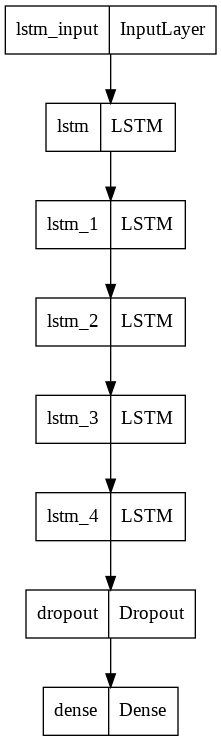

In [84]:
best_model = tuner.get_best_models(num_models=1)[0]
print(tuner.results_summary())
plot_model(best_model, to_file='model.png')

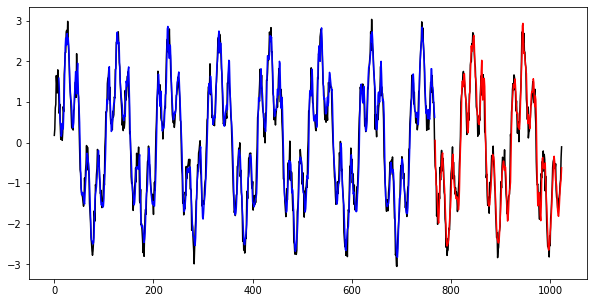

In [85]:
trainPredict = best_model.predict(train_data_gen)
testPredict = best_model.predict(test_data_gen)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(np.r_[look_back:threshold], trainPredict,'b')
plt.plot(np.r_[threshold:F.shape[0]], testPredict, 'r')
plt.show()

Построим  прогноз  на 256 точек  для  следующего  модельного временного ряда:

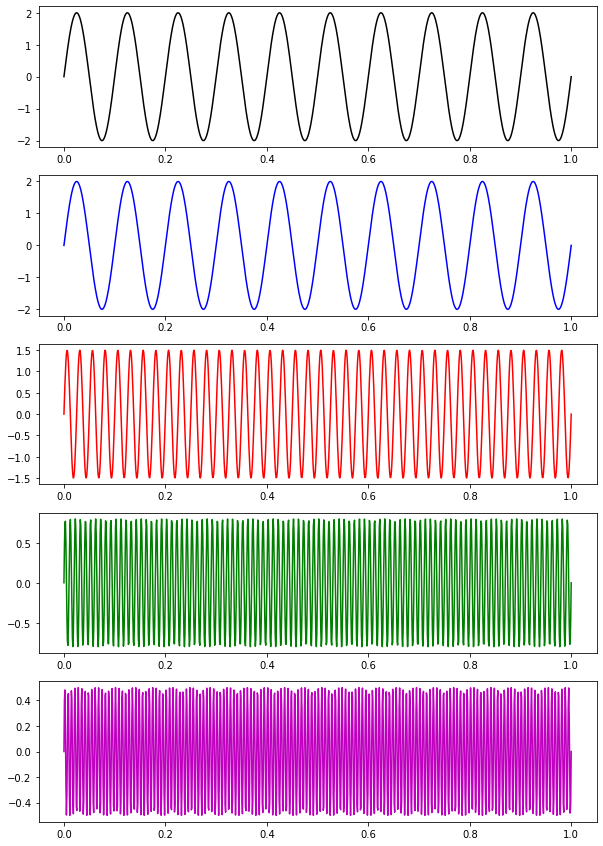

In [86]:
t = np.linspace(0,1,1024)
f1 = 10
f2 = 40
f3 = 100
f4 = 150

F = 2.0*np.sin(2*np.pi*f1*t) 
+ 1.5*np.sin(2*np.pi*f2*t) 
+ 0.8*np.sin(2*np.pi*f3*t) 
+ 0.5*np.sin(2*np.pi*f4*t) 
+ np.random.randn(len(t))

plt.figure(figsize = (10, 15))
plt.subplot(5,1,1)
plt.plot(t, F, 'k')
plt.subplot(5,1,2)
plt.plot(t, 2.0*np.sin(2*np.pi*f1*t), 'b')
plt.subplot(5,1,3)
plt.plot(t, 1.5*np.sin(2*np.pi*f2*t), 'r')
plt.subplot(5,1,4)
plt.plot(t, 0.8*np.sin(2*np.pi*f3*t), 'g')
plt.subplot(5,1,5)
plt.plot(t, 0.5*np.sin(2*np.pi*f4*t), 'm')
plt.show()

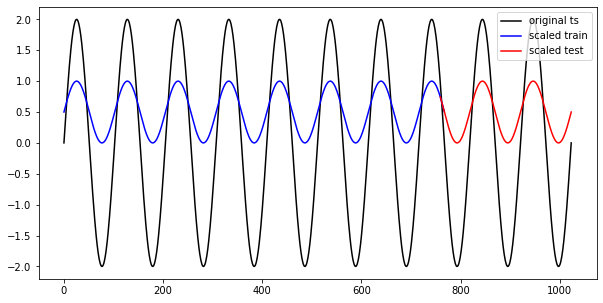

In [87]:
look_back = 10
threshold = 768

scaler = MinMaxScaler(feature_range=(0, 1))
Fs = scaler.fit_transform(F.reshape(-1, 1))
F_tr = Fs[:threshold]
F_test = Fs[threshold-look_back:]

plt.figure(figsize = (10, 5))
plt.plot(F, 'k', label = 'original ts')
plt.plot(np.r_[:threshold], F_tr, 'b', label='scaled train')
plt.plot(np.r_[threshold-look_back:F.shape[0]], F_test, 'r', label='scaled test')
plt.legend()
plt.show()

In [92]:
train_data_gen = TimeseriesGenerator(F_tr, 
                                     F_tr,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=6)

test_data_gen = TimeseriesGenerator(F_test, 
                                    F_test,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1)

In [98]:
tuner = RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1,
        directory='tuner_2')

In [99]:
tuner.search(
        train_data_gen,
        epochs=20,
        batch_size=10,
        validation_data=test_data_gen)

Trial 2 Complete [00h 02m 54s]
mse: 0.000831178214866668

Best mse So Far: 0.000831178214866668
Total elapsed time: 00h 05m 51s
INFO:tensorflow:Oracle triggered exit


Results summary
Results in tuner_2/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 45
n_layers: 2
lstm_0_units: 35
layer_2_neurons: 45
Dropout_rate: 0.1
dense_activation: sigmoid
lstm_1_units: 45
Score: 0.000831178214866668
Trial summary
Hyperparameters:
input_unit: 45
n_layers: 2
lstm_0_units: 45
layer_2_neurons: 45
Dropout_rate: 0.4
dense_activation: relu
lstm_1_units: 35
Score: 0.004835531581193209
None


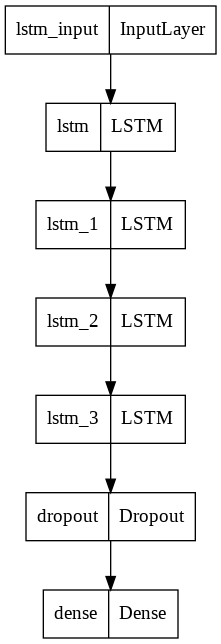

In [100]:
best_model = tuner.get_best_models(num_models=1)[0]
print(tuner.results_summary())
plot_model(best_model, to_file='model.png')

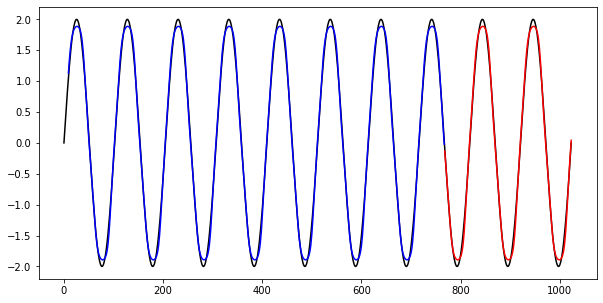

In [101]:
trainPredict = best_model.predict(train_data_gen)
testPredict = best_model.predict(test_data_gen)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(np.r_[look_back:threshold], trainPredict,'b')
plt.plot(np.r_[threshold:F.shape[0]], testPredict, 'r')
plt.show()